In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn.preprocessing as preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, cross_val_score
from numpy import mean

Location of the train and test data can be changed accordingly.

In [69]:
# MAKE CHANGES IN THE DATA LOCATION ACCORDINGLY

train_data_location=input("Enter the path to train data: ")
test_data_location=input("Enter the path to train data: ")
save_directory=input("Enter the path to directory where the predictions are to be saved: ")

features = pd.read_csv(train_data_location)
test_data = pd.read_csv(test_data_location)
features

Enter the path to train data: /content/drive/MyDrive/cs253_ml/train.csv
Enter the path to train data: /content/drive/MyDrive/cs253_ml/test.csv
Enter the path to directory where the predictions are to be saved: /content/drive/MyDrive/cs253_ml


,ID,Candidate,Constituency ∇,Party,Criminal Case,Total Assets,Liabilities,state,Education
0,0,M.K. Mohan,ANNA NAGAR,DMK,4,211 Crore+,2 Crore+,TAMIL NADU,8th Pass
1,1,Khatik Ramesh Prasad,KARERA (SC),BJP,0,1 Crore+,0,MADHYA PRADESH,12th Pass
2,2,Dr. Mantar Gowda,MADIKERI,INC,0,7 Crore+,22 Lac+,KARNATAKA,Post Graduate
3,3,Kundan Kumar,BEGUSARAI,BJP,0,9 Crore+,24 Lac+,BIHAR,Post Graduate
4,4,Swapan Majumder,BANGAON DAKSHIN (SC),BJP,2,2 Crore+,61 Lac+,WEST BENGAL,8th Pass
...,...,...,...,...,...,...,...,...,...
2054,2054,V. Sasi,CHIRAYINKEEZHU,CPI,1,61 Lac+,10 Lac+,KERALA,Graduate Professional
2055,2055,Pushkar Lal Dangi,MAVLI,INC,0,2 Crore+,8 Lac+,RAJASTHAN,10th Pass
2056,2056,Dr. Manju Shiwach,MODI NAGAR,BJP,0,13 Crore+,85 Lac+,UTTAR PRADESH,Graduate
2057,2057,Mansing Fattesingrao Naik,SHIRALA,NCP,1,25 Crore+,94 Lac+,MAHARASHTRA,12th Pass


Lets make a bar plot to understand the the density of samples from various states.

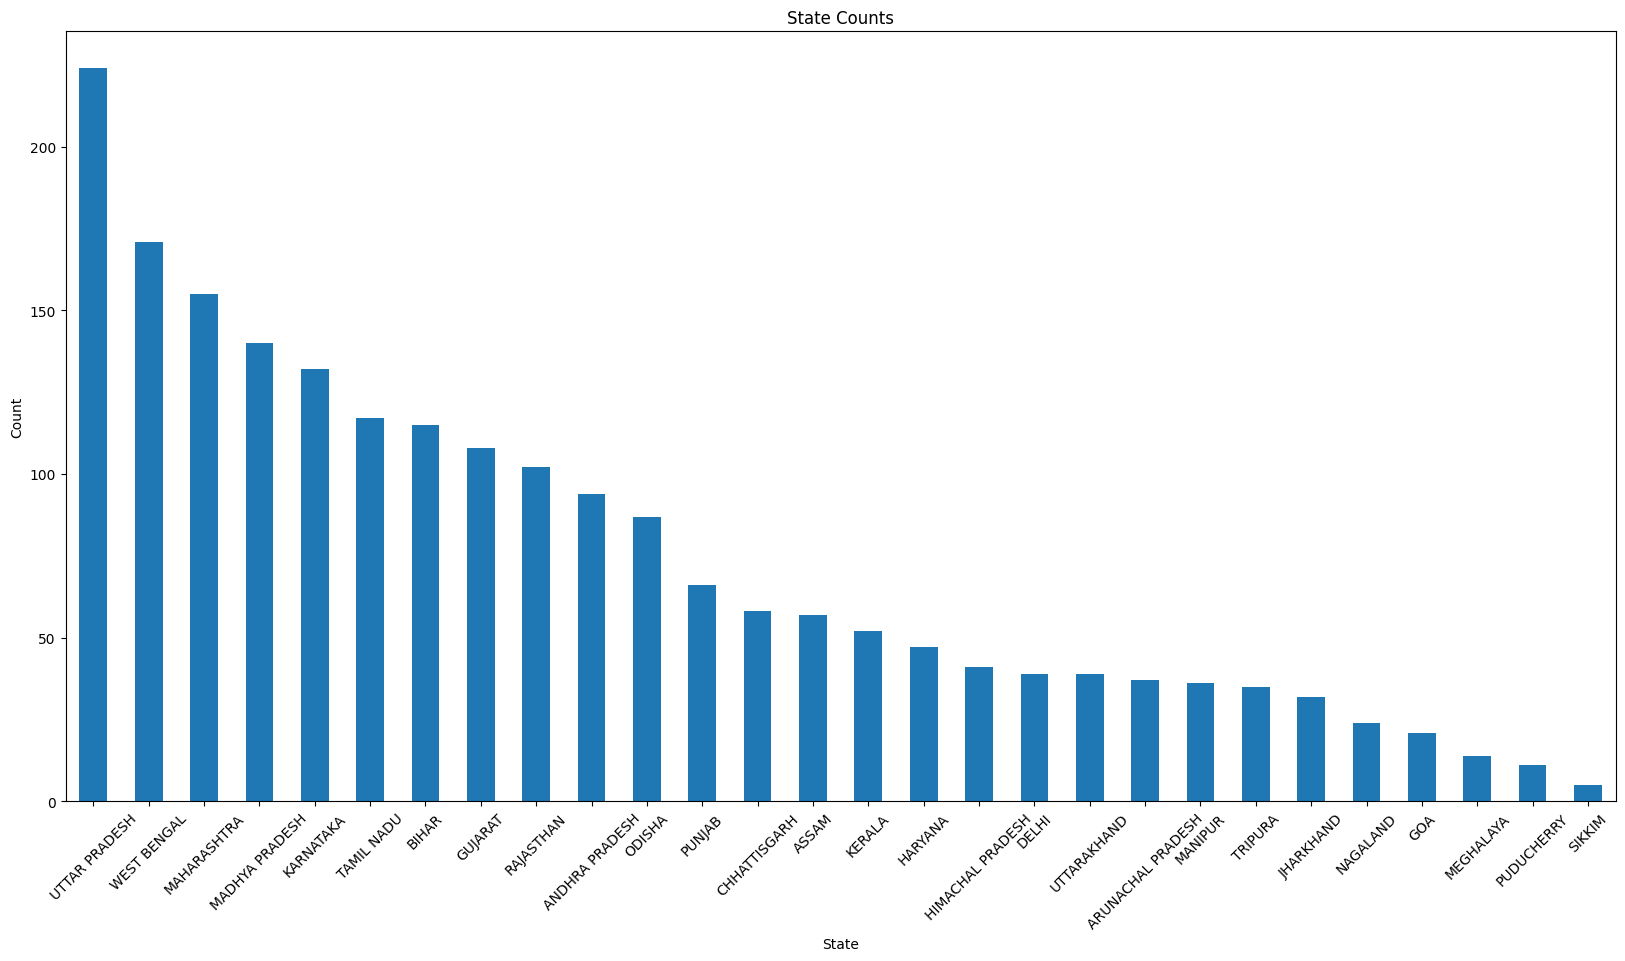

In [70]:
state_counts = features['state'].value_counts()
education_counts = features['Education'].value_counts()

# Plotting state counts
plt.figure(figsize=(20, 10))
state_counts.plot(kind='bar')
plt.title('State Counts')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Now we make a bar plot to understand the class imbalance that exists in the target variable 'Education'

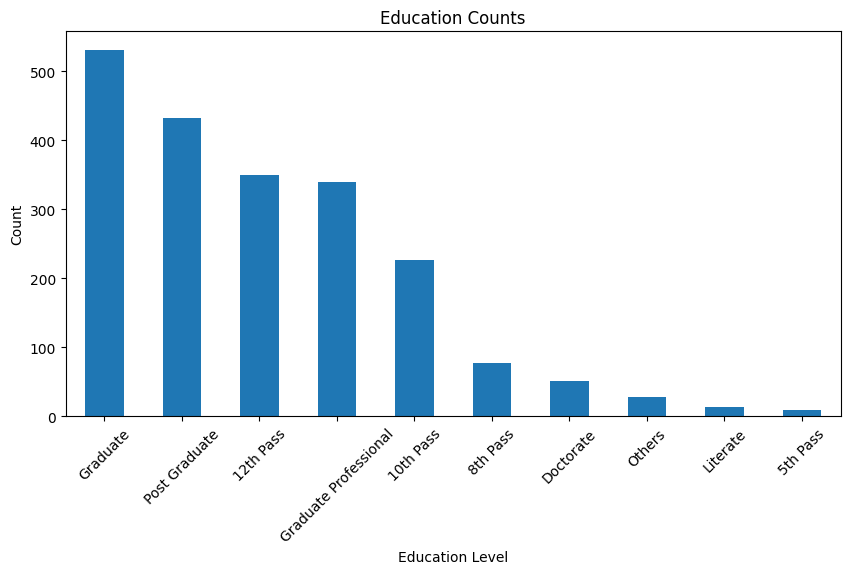

In [71]:
# Plotting education counts
plt.figure(figsize=(10, 5))
education_counts.plot(kind='bar')
plt.title('Education Counts')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

We add new columns 'asset_label' and 'liab_label' which uses labels 'crore', 'lakhs', 'thousand', 'hundred' for broadly describing total assets and liabilities.

In [72]:
def add_rough_asset(features, column, new_column):
  new_col=[]
  for entry in features[column]:
    if entry >= 10000000:
      new_col.append('crore')
    elif entry >= 1_00_000 and entry < 10000000:
      new_col.append('lakh')
    elif entry >= 1_000 and entry < 1_00_000:
      new_col.append('thousand')
    else:
       new_col.append('hundred')

  features[new_column]=new_col
  return features

Preprocessing the data included removal of unimportant features, converting total assets and liabilities to numeric values, etc.

In [73]:
def preprocess_numeric(entry):
        # Extract numeric part
        numeric_part = int(entry.split()[0])
        # Check the part following the numeric value
        if 'Crore+' in entry:
            return numeric_part * 10_000_000, 'Crore'
        elif 'Lac+' in entry:
            return numeric_part * 100_000, 'Lakh'
        elif 'Thou+' in entry:
            return numeric_part * 1_000, 'Thou'
        else:
            return numeric_part * 100, 'Hund'

def preprocess_numeric_to_label(entry):
        # Extract numeric part
        numeric_part = int(entry.split()[0])
        # Check the part following the numeric value
        if 'Crore+' in entry:
            return 'Crore'
        elif 'Lac+' in entry:
            return 'Lakh'
        elif 'Thou+' in entry:
            return 'Thou'
        elif 'Hund+' in entry:
            return 'Hund'

def preprocess(features):
  numeric_liab=[]
  numeric_asset=[]

  asset_label=[]
  liab_label=[]

  for entry in features['Liabilities']:
    new_entry, new_entry_label = preprocess_numeric(entry)
    numeric_liab.append(new_entry)
    liab_label.append(new_entry_label)

  for entry in features['Total Assets']:
    new_entry, new_entry_label = preprocess_numeric(entry)
    numeric_asset.append(new_entry)
    asset_label.append(new_entry_label)

  features = features.assign(numeric_asset=numeric_asset)
  features = features.assign(numeric_liab=numeric_liab)
  features = features.assign(liab_label=liab_label)
  features = features.assign(asset_label=asset_label)

  features = features.drop(['Total Assets', 'Liabilities', 'Candidate', 'Constituency ∇', 'ID'], axis=1)

  return features




In [74]:
features = preprocess(features)

In [75]:
def hot_encode(features):
  features_one_hot = pd.get_dummies(data = features, columns = ["state", "Party"], prefix = "is")
  return features_one_hot

Making plots to understand the data.

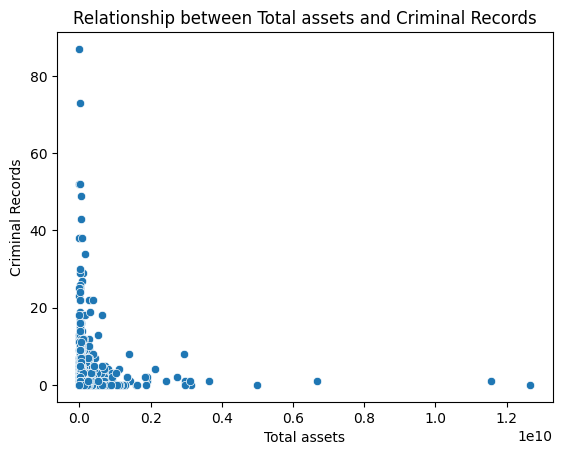

In [76]:
# scatter plot between 'Total assets' and 'criminal record'
sb.scatterplot(x='numeric_asset', y='Criminal Case', data=features)
plt.title('Relationship between Total assets and Criminal Records')
plt.xlabel('Total assets')
plt.ylabel('Criminal Records')
plt.show()

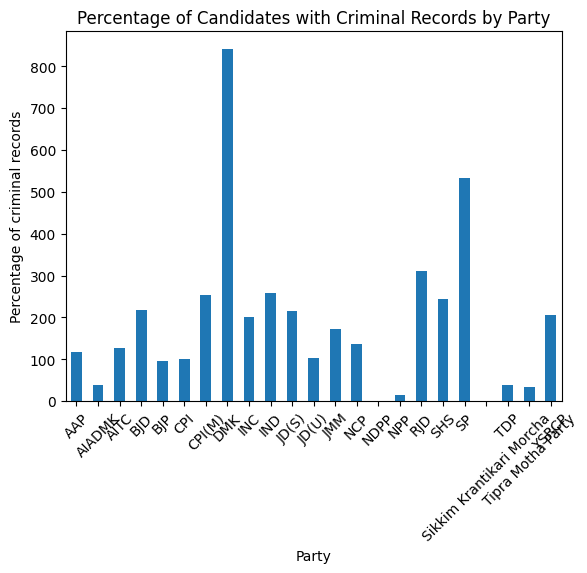

In [77]:
# Plot the percentage distribution of parties with candidates having the most criminal records
criminal_records = features.groupby('Party')['Criminal Case'].sum()
criminal_records_percentage = (criminal_records / features.groupby('Party')['Criminal Case'].count()) * 100
criminal_records_percentage.plot(kind='bar', title='Percentage of Candidates with Criminal Records by Party')
plt.xlabel('Party')
plt.ylabel('Percentage of criminal records')
plt.xticks(rotation=45)
plt.show()

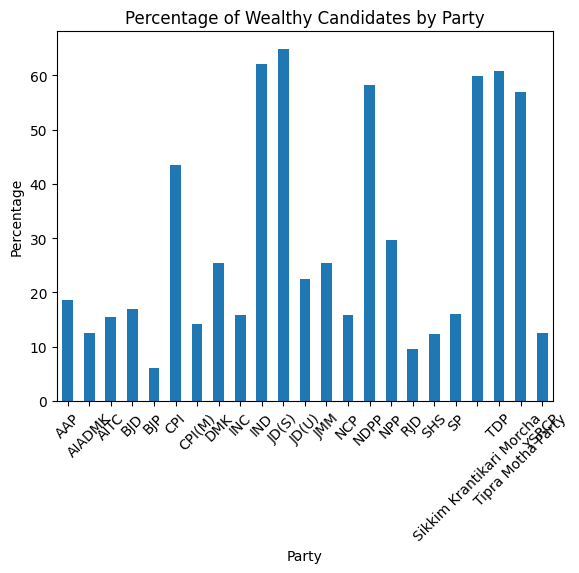

In [78]:
# Plot the percentage distribution of parties with the most wealthy candidates
wealthy_candidates = features.groupby('Party')['numeric_asset'].max()
wealthy_candidates_percentage = (wealthy_candidates / features.groupby('Party')['numeric_asset'].sum()) * 100
wealthy_candidates_percentage.plot(kind='bar', title='Percentage of Wealthy Candidates by Party')
plt.xlabel('Party')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.show()

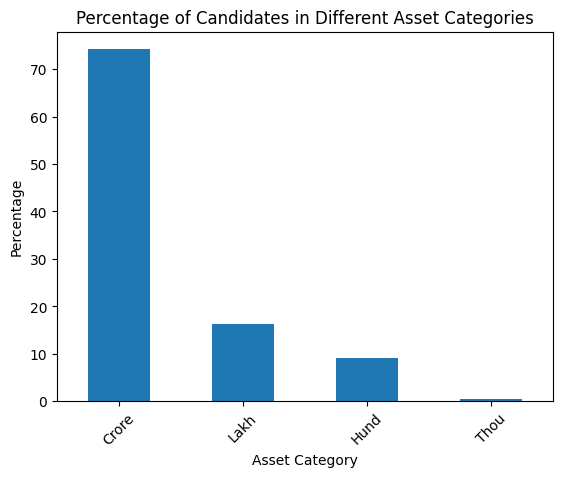

In [79]:
# Calculate the percentage of candidates in each asset category
asset_category_percentage = (features['asset_label'].value_counts() / len(features)) * 100

# Plot the percentage distribution of candidates in different asset categories
asset_category_percentage.plot(kind='bar', title='Percentage of Candidates in Different Asset Categories')
plt.xlabel('Asset Category')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.show()

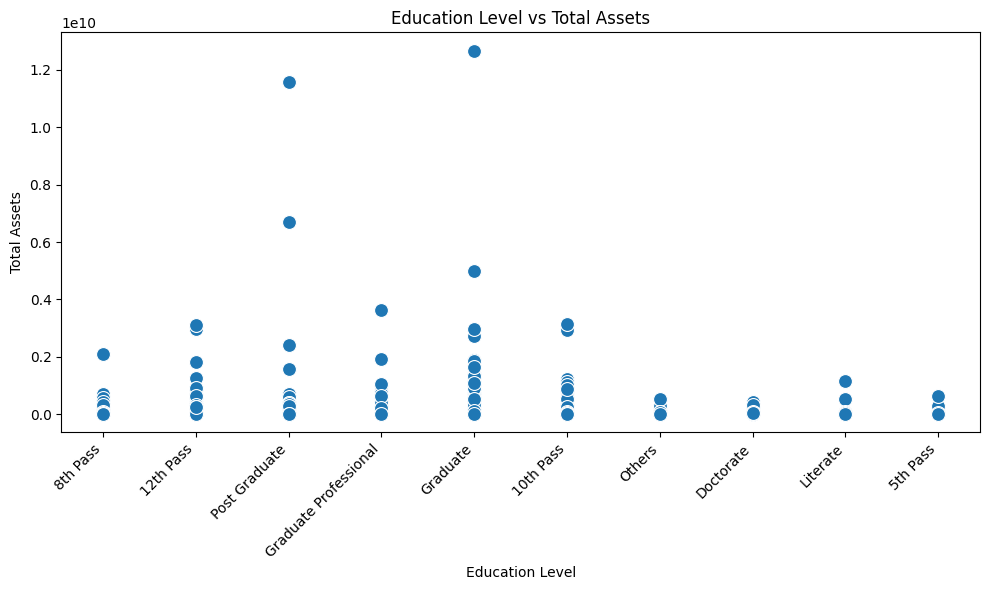

In [80]:
# Plot of education level and total assets
plt.figure(figsize=(10, 6))
sb.scatterplot(data=features, x='Education', y='numeric_asset', s=100)
plt.xticks(rotation=45, ha='right')
plt.title('Education Level vs Total Assets')
plt.xlabel('Education Level')
plt.ylabel('Total Assets')
plt.tight_layout()
plt.show()

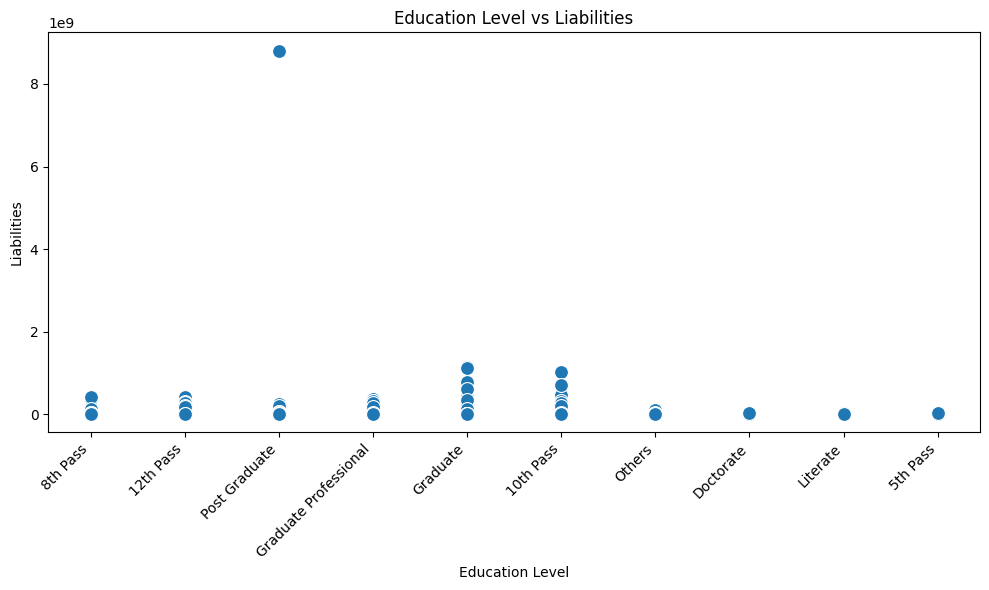

In [81]:
# Plot of education level and liabilities
plt.figure(figsize=(10, 6))
sb.scatterplot(data=features, x='Education', y='numeric_liab', s=100)
plt.xticks(rotation=45, ha='right')
plt.title('Education Level vs Liabilities')
plt.xlabel('Education Level')
plt.ylabel('Liabilities')
plt.tight_layout()
plt.show()

As it can be seen there exists classs imbalance in the target variable. For resolving this issue, we implement class weights thta will be fed to the classifier.

In [82]:
def return_class_balancing_weights(df, column_name):
    # Get the frequencies of each class in the specified column
    frequencies = df[column_name].value_counts().reset_index()
    frequencies.columns = [column_name, 'Frequency']

    # Calculate total samples
    total_samples = frequencies['Frequency'].sum()

    # Calculate weights for each class
    frequencies['Weight'] = total_samples / (frequencies['Frequency'] * len(frequencies))

    return frequencies

In [83]:
#one hot encoding discrete variables
features = hot_encode(features)
features = features.drop(['asset_label', 'liab_label', 'numeric_liab', 'numeric_asset'], axis=1)

# encoding education levels to numeric values
label_encoder = preprocessing.LabelEncoder()
features['Education'] = label_encoder.fit_transform(features['Education'])

# making weights
weights_train = return_class_balancing_weights(features, 'Education')
education_weights_train = dict(zip(weights_train['Education'], weights_train['Weight']))

In [84]:
# preprocessing test data
test_data = preprocess(test_data)
test_data = test_data.drop(['asset_label', 'liab_label', 'numeric_liab', 'numeric_asset'], axis=1)
test_data = hot_encode(test_data)

In [85]:
print(education_weights_train)

{5: 0.38775894538606404, 9: 0.47662037037037036, 1: 0.5899713467048711, 6: 0.6073746312684366, 0: 0.9070484581497797, 3: 2.6397435897435897, 4: 3.9596153846153848, 8: 7.353571428571429, 7: 14.707142857142857, 2: 22.877777777777776}


In [86]:
# Split the data into features (X) and target (y)
X = features.drop('Education', axis=1)
y = features['Education']
print(features)

      Criminal Case  Education  is_ANDHRA PRADESH  is_ARUNACHAL PRADESH  \
0                 4          3              False                 False   
1                 0          1              False                 False   
2                 0          9              False                 False   
3                 0          9              False                 False   
4                 2          3              False                 False   
...             ...        ...                ...                   ...   
2054              1          6              False                 False   
2055              0          0              False                 False   
2056              0          5              False                 False   
2057              1          1              False                 False   
2058              0          5              False                  True   

      is_ASSAM  is_BIHAR  is_CHHATTISGARH  is_DELHI  is_GOA  is_GUJARAT  ...  \
0        False     

In [87]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [88]:
clf = ExtraTreesClassifier(n_estimators = 175, max_depth = 50, max_features = 4, bootstrap = True)
print(clf)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')

print("F1 score:", f1)

ExtraTreesClassifier(bootstrap=True, max_depth=50, max_features=4,
                     n_estimators=175)
F1 score: 0.2125586997388848


In [89]:
#for obtaining test data results
predictions = clf.predict(test_data)
decoded_predictions = label_encoder.inverse_transform(predictions)

In [92]:
# Convert the decoded predictions to a DataFrame
predictions_df = pd.DataFrame(decoded_predictions, columns=['Predictions'])
predictions_df.insert(0, 'ID', range(len(predictions_df)))
file_path = save_directory +'predictions.csv'

# Save the DataFrame to the specified location
predictions_df.to_csv(file_path, index=False)